# Weedle's Cave challenge in R 
## Predicting wins and losses between pokémon in Gen 1

### This is "Weedle's Cave" challenge. Can we build a model that'll predict which pocket monster will win or lose?

##### Personal objectives: Get familiar with R.

## Contents

- <a id='section1'>1. Library List</a>
- <a id='section2'>2. Data import and exploration</a>
- <a id='section3'>3. Data Quality checks</a>
- <a id='section4'>4. Feature Engineering</a>
- <a id='section5'>5. Modelling and parameter tuning</a>
- <a id='section6'>6. Testing on the training data</a>

<a id='section1'></a>

# Section 1: Libraries list

In [35]:
library(ggthemes)
library(ggplot2)
library(dplyr)
library(fmsb)

<a id='section2'></a>

# Section 2: Data Import and Exploration

###### First, Read in the data! We'll read in the pokémon list, the combats that we'll model from, and the final test data that we need to populate for our Kaggle submission. Should be self explanatory, but the super high-level workflow is as follows:

1. Profile/clean/investigate the data
2. Build some models and see what works well
3. Apply the final chosen model to our test data for our Kaggle submission

In [36]:
# first row contains variable names, comma is separator 
# assign the variable id to row names
# note the / instead of \ on mswindows systems 

data_pokemon <- read.csv("/Users/kintesh/Documents/kaggle/pokemon/data/pokemon.csv")
data_combats <- read.csv("/Users/kintesh/Documents/kaggle/pokemon/data/combats.csv")
data_tests <- read.csv("/Users/kintesh/Documents/kaggle/pokemon/data/tests.csv")
# mydata <- read.table("/Users/kintesh/Documents/kaggle/pokemon/data/pokemon.csv", header=TRUE, 
#    sep=",", row.names="id", quote="")

colnames(data_pokemon) = c('PokeNum', 'Name', 'Type1', 'Type2', 'HP', 'Attack', 
                           'Defense', 'SpAtk', 'SpDef', 'Speed', 'Generation', 'Legendary')

In [37]:
head(data_pokemon,5)
head(data_combats,5)
head(data_tests,5)

PokeNum,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,,39,52,43,60,50,65,1,False


First_pokemon,Second_pokemon,Winner
266,298,298
702,701,701
191,668,668
237,683,683
151,231,151


First_pokemon,Second_pokemon
129,117
660,211
706,115
195,618
27,656


######  Let's get information on the battles and their outcomes - what was pokemon 1, what was their type, etc etc? But first, rename the columns so we can merge more easily.

In [38]:
# Create a CombatID for each combat in the combats dataset, just in case we need to join back later. 
# Using the column bind function to do so.

id <- rownames(data_combats)
data_combats2 <- cbind(id=id, data_combats)

colnames(data_combats2) <- c('CombatID', 'First_pokemon', 'Second_pokemon', 'Winner')
# Convert CombatID field to numeric
data_combats2[,'CombatID'] <- as.numeric(as.character(data_combats2[,'CombatID']))

pokemon_first <- data_combats2[c('CombatID', 'First_pokemon')]
colnames(pokemon_first) = c("CombatID", "PokeNum")

pokemon_second <- data_combats2[c('CombatID', 'Second_pokemon')]
colnames(pokemon_second) = c("CombatID", "PokeNum")

head(data_combats2,5)
head(pokemon_first,5)
head(pokemon_second,5)

CombatID,First_pokemon,Second_pokemon,Winner
1,266,298,298
2,702,701,701
3,191,668,668
4,237,683,683
5,151,231,151


CombatID,PokeNum
1,266
2,702
3,191
4,237
5,151


CombatID,PokeNum
1,298
2,701
3,668
4,683
5,231


######  Merge on the pokemon stats for the first pokemon, then do the same for the second pokemon, and colour code each type.

In [39]:
# Check the types in each column before we begin.
# sapply(data_pokemon, class)
# sapply(pokemon_first, class)
# sapply(pokemon_second, class)

# Also, add colours on from the unofficial pokemon forum place:
# http://www.epidemicjohto.com/t882-type-colors-hex-colors

Type1 <- c("Dragon","Steel","Flying","Psychic","Rock" ,"Fire","Electric" ,"Dark","Ghost" ,"Ground","Ice", "Water","Grass","Fighting", "Fairy" ,"Poison","Normal","Bug")
Colour <- c("#6F35FC","#B7B7CE","#A98FF3","#F95587","#B6A136","#EE8130","#F7D02C","#705746","#735797","#E2BF65","#96D9D6","#6390F0","#7AC74C","#C22E28","#D685AD","#A33EA1","#A8A77A","#A6B91A")

TypeColourMapping <-data.frame(Type1, Colour)

c1 <- merge(x = pokemon_first,  y = data_pokemon, by = "PokeNum", all.x = TRUE)
c2 <- merge(x = pokemon_second, y = data_pokemon, by = 'PokeNum', all.x = TRUE)

combats_1_stats <- merge(x = c1, y = TypeColourMapping, by = "Type1", all.x = TRUE)
combats_2_stats <- merge(x = c2, y = TypeColourMapping, by = 'Type1', all.x = TRUE)

# Order the data in place
combats_1_stats <- combats_1_stats[order(combats_1_stats$CombatID),]
combats_2_stats <- combats_2_stats[order(combats_2_stats$CombatID),] 

tail(combats_1_stats,5)
tail(combats_2_stats,5)

,Type1,PokeNum,CombatID,Name,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary,Colour
7256,Dragon,707,49996,Reshiram,Fire,100,120,100,150,120,90,5,True,#6F35FC
25145,Ground,589,49997,Drilbur,,60,85,40,30,45,68,5,False,#E2BF65
45914,Water,303,49998,Pelipper,Flying,60,50,100,85,70,65,3,False,#6390F0
10212,Electric,109,49999,Voltorb,,40,30,50,55,55,100,1,False,#F7D02C
14260,Fire,9,50000,Mega Charizard Y,Flying,78,104,78,159,115,100,1,False,#EE8130


,Type1,PokeNum,CombatID,Name,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary,Colour
43919,Water,126,49996,Horsea,,30,40,70,70,25,60,1,False,#6390F0
10011,Electric,664,49997,Tynamo,,35,55,40,45,40,60,5,False,#F7D02C
29731,Normal,368,49998,Zangoose,,73,115,60,60,60,90,3,False,#A8A77A
10411,Electric,89,49999,Magnemite,Steel,25,35,70,95,55,45,1,False,#F7D02C
12988,Fighting,73,50000,Machop,,70,80,50,35,35,35,1,False,#C22E28


###### Plot the frequency of each type in descending order... but create the underlying table first (by grouping and merging the colours on again).

Note, I tried doing it off the underlying dataset in one go but that didn't work.

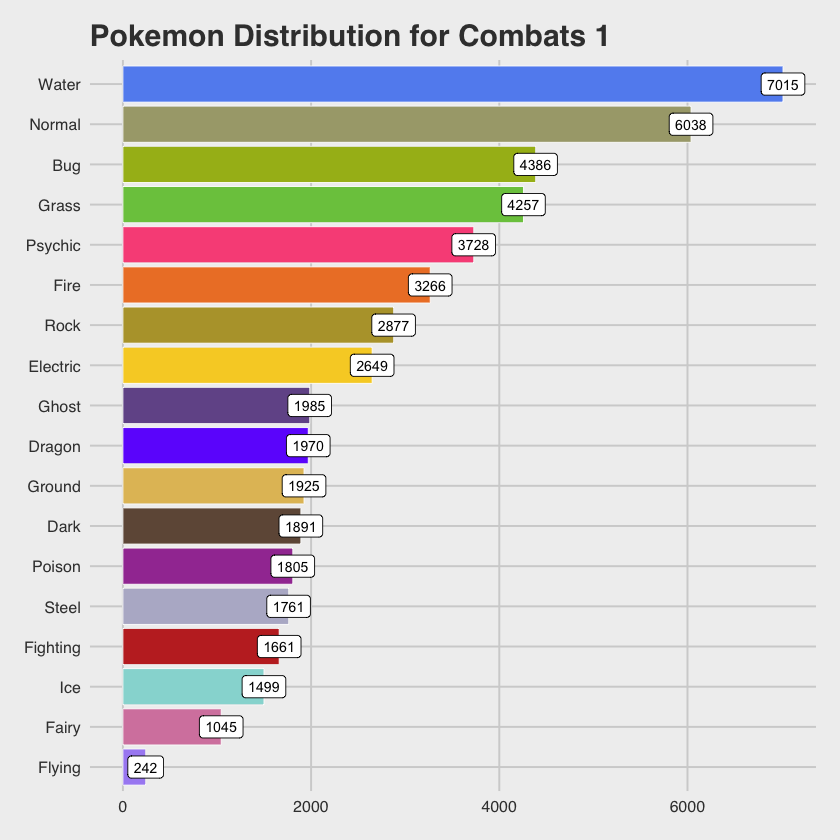

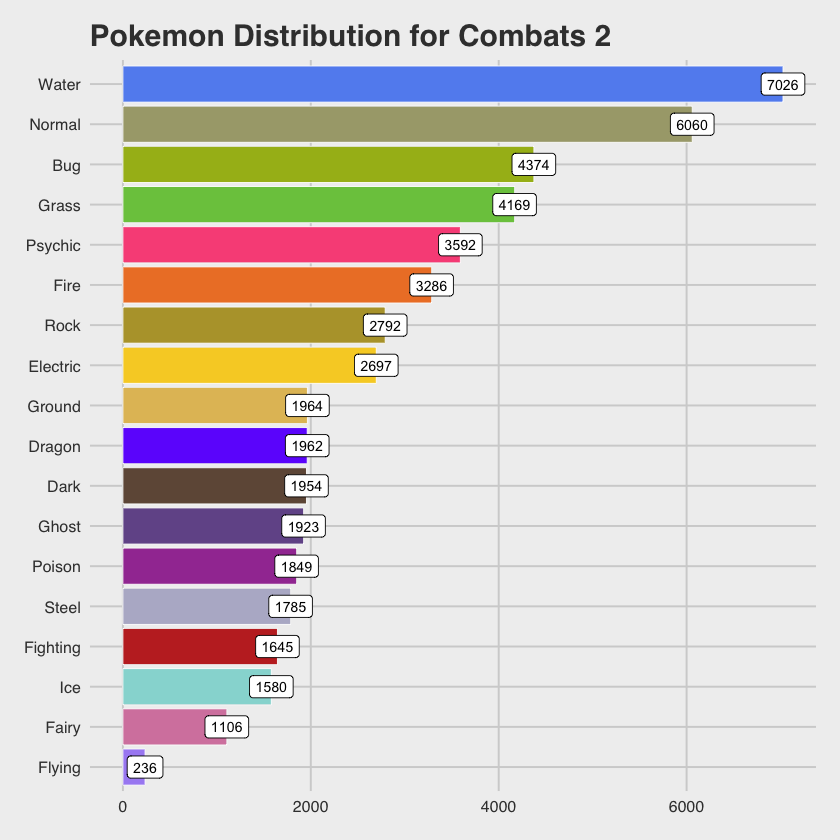

In [40]:
chart_dataA1 <- group_by(combats_1_stats[c("Type1","Colour")], Type1)
chart_dataA2 <- summarize(chart_dataA1, Total = n())
chart_dataA3 <- merge(x = chart_dataA2, y = TypeColourMapping, by = "Type1", all.x = TRUE)

ggplot(chart_dataA3, aes(x=reorder(Type1,Total),y=Total)) +
         geom_bar(stat = "identity") + 
  geom_bar(aes(fill=Colour),color='white',size=.25,stat='identity') + 
  scale_fill_identity() + coord_flip() + theme_fivethirtyeight() + 
  ggtitle("Pokemon Distribution for Combats 1") +
     geom_label(aes(label=Total), size=3, position = position_dodge(0.9))

chart_dataB1 <- group_by(combats_2_stats[c("Type1","Colour")], Type1)
chart_dataB2 <- summarize(chart_dataB1, Total = n())
chart_dataB3 <- merge(x = chart_dataB2, y = TypeColourMapping, by = "Type1", all.x = TRUE)

ggplot(chart_dataB3, aes(x=reorder(Type1,Total),y=Total)) +
         geom_bar(stat = "identity") + 
  geom_bar(aes(fill=Colour),color='white',size=.25,stat='identity') + 
  scale_fill_identity() + coord_flip() + theme_fivethirtyeight() + 
  ggtitle("Pokemon Distribution for Combats 2") +
    geom_label(aes(label=Total), size=3, position = position_dodge(0.9))

###### Average statistics by pokemon type. What do we expect is the most powerful type?

In [41]:
# Get plot data ready.
plot_dataA1 <- group_by(data_pokemon[c("Type1", 'HP', 'Attack', 
                           'Defense', 'SpAtk', 'SpDef', 'Speed')], Type1)

# Summarise each statistic by mean, and remove any NAs if applicable.
plot_dataA2 <- summarize(plot_dataA1, Total = n(), 
                          AvgHP = mean(HP, na.rm = TRUE),
                          AvgAtk = mean(Attack, na.rm = TRUE),
                          AvgDef = mean(Defense, na.rm = TRUE),
                          AvgSpA = mean(SpAtk, na.rm = TRUE),
                          AvgSpD = mean(SpDef, na.rm = TRUE),
                          AvgSpe = mean(Speed, na.rm = TRUE)
                         )

# Take off the total column for now.
plot_dataA2 <- plot_dataA2[c("Type1", 'AvgHP', 'AvgAtk', 'AvgDef', 'AvgSpA', 'AvgSpD', 'AvgSpe')]
plot_data_loop_base <- merge(x = plot_dataA2, y = TypeColourMapping, by = "Type1", all.x = TRUE)

# Create a standard col list for the type and the stat columns only.
ColList <- c("Type1", 'AvgHP', 'AvgAtk', 'AvgDef', 'AvgSpA', 'AvgSpD', 'AvgSpe')

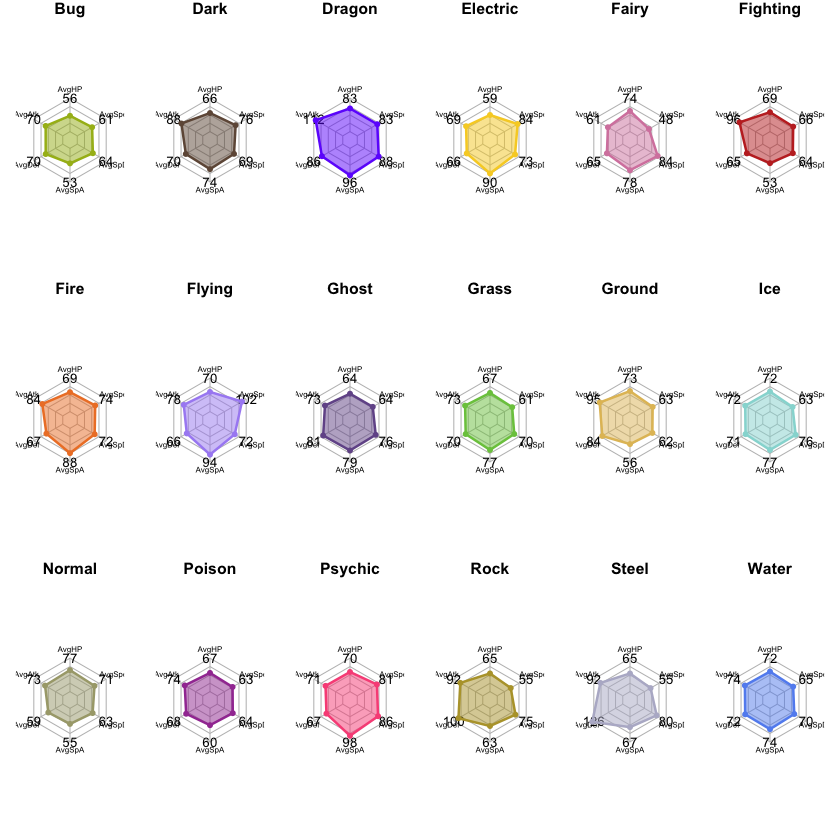

In [42]:
# Create a grid, 6 wide and 3 down for these plots.

par(mfrow=c(3,6))
par(mar=c(1,1,1,1))

# Loop over the rows in our dataset and plot these graphs.

# for(i in 1:nrow(plot_data_loop_base))

for(i in 1:nrow(plot_data_loop_base)){
    # Subset for only one line (this is what we'll be looping over)
PlotDataSubset <- subset(plot_data_loop_base, Type1 %in% as.character(plot_data_loop_base$Type1[i]))

# To use the fmsb package, we have to add 2 lines to the dataframe
# These are the max and min of each stat to show on the plot!
                     
addMin <- data.frame("Min",0,0,0,0,0,0)
names(addMin) <- ColList

addMax <- data.frame("Max",120,120,120,120,120,120)
names(addMax) <- ColList

PlotDataSubset2 <- rbind(rbind(addMax, addMin), PlotDataSubset[ColList])

PlotDataFinal <- PlotDataSubset2[c('AvgHP', 'AvgAtk', 'AvgDef', 'AvgSpA', 'AvgSpD', 'AvgSpe')]

# Convert Hex Colour to RGB
Current_RGB_Colour <-(col2rgb(as.character(plot_data_loop_base$Colour[i])) %>% as.integer())/255

# Custom the radarChart
radarchart( PlotDataFinal  , axistype=2 ,
           
     #custom polygon colours
     pcol=rgb(Current_RGB_Colour[1],Current_RGB_Colour[2],Current_RGB_Colour[3], alpha = 1) ,
     pfcol=rgb(Current_RGB_Colour[1],Current_RGB_Colour[2],Current_RGB_Colour[3],.5) ,

    # custom the chart
     plwd=2 , 
     cglcol="grey", 
     cglty=1, 
     axislabcol="black", 
#      caxislabels=seq(0,2000,5), 
# Take axis labels from the plot data final tab
     paxislabels = as.integer(as.vector(PlotDataFinal[3,])),
     cglwd=0.8, 
     vlcex=0.6,
    # Add a title
    title=as.character(plot_data_loop_base$Type1[i]))
}

<a id='section3'></a>

# Section 3: Data Quality Checks

###### Before we go ahead and start feature engineering, we should probably do a few data quality checks to ensure all our columns are fit for purpose. Since this is Kaggle data, it's pretty likely it will be... but let's check, shall we?

First, we'll create one 'super' dataset with information on combat 1 vs combat 2, and their statistics. Basically we're merging combats_1_stats and combats_2_stats that we made above.